In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvisa
import time
from tqdm.notebook import tqdm

factor = 2
SMALL_SIZE = factor*8
MEDIUM_SIZE = factor*10
BIGGER_SIZE = factor*12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
# list available devices
rm = pyvisa.ResourceManager()
print(rm.list_resources())

('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR', 'ASRL4::INSTR')


In [3]:
# open connections to devices
SynthHD = rm.open_resource('ASRL4::INSTR')
# arduino = rm.open_resource('ASRL3::INSTR')
# power_meter = rm.open_resource('USB0::0x0AAD::0x0161::101074::INSTR')
scope = rm.open_resource('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

In [5]:
# initialize devices
power_meter.write('*RST')
power_meter.write('UNIT:POW DBM')
power_meter.write('SENS:FREQ 85e6')
power_meter.write('SENS:POW:AVG:FAST ON');

In [33]:
def measure_scope(ch_list=[1]):
    data = []
    for ch in ch_list:
#         scope.write(":MEASure:ITEM VAVG, channel"+str(ch))
        raw_data = scope.query(":MEASure:ITEM? VAVG, channel"+str(ch))
        try:
            float_data = float(raw_data.strip())
            if float_data < 1e9:
                data.append( float_data )
            else:
                raise TypeError
        except TypeError:
            data.append(np.nan)
    return data

In [63]:
# turn RF on
SynthHD.write('C0f85W-46.0E1r1')

# measure data
data = []
for power in tqdm(range(-15,17)):
    SynthHD.write(f'W{power}')
    time.sleep(0.4)
    data.append([power, *measure_scope()])

# turn RF off
SynthHD.write(f'W-46')
SynthHD.write('E0r0')
time.sleep(0.25)

# convert data
data = np.array(data)

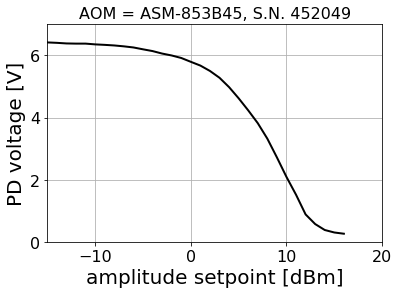

In [65]:
plt.plot(data[:,0], data[:,1], lw=2, color='black')
plt.xlabel("amplitude setpoint [dBm]")
plt.ylabel("PD voltage [V]")
plt.title("AOM = ASM-853B45, S.N. 452049")
plt.ylim([0,7])
plt.xlim([-15,20])
plt.grid()